# Treinamento do modelo
- tokenização
- treinamento
- verificação de desempenho
---
### Tópicos para produção
1. tokenização
2. definição do modelo a ser usado
3. argumentos
4. definição das métricas de avaliação
5. treinamento
6. ajuste de hiperparâmetro
7. rotulação do teste

In [1]:
!pip install transformers
!pip install datasets
!pip install optuna
!pip install evaluate
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [2]:
!pip install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
#bibliotecas:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification,TrainingArguments, Trainer, EarlyStoppingCallback, AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict
import numpy as np
import optuna
from evaluate import load
import shap
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # garantir que seja rodado pela GPU
print(f"Treinando no dispositivo: {device}")

Treinando no dispositivo: cuda


In [6]:
banco = pd.read_csv("/content/rotulados_antes_treino_v2.csv") # mudar para banco geral rotulado
banco["mensagem"] = banco["mensagem"].astype(str) # garantir que os dados estejam no formato correto, a saber: "mensagem" (str), "aspecto" (str) e "sentimento" (int)
banco["aspecto"] = banco["aspecto"].astype(str)
banco["sentimento"] = banco["sentimento"].astype(int)
banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mensagem    937 non-null    object
 1   aspecto     937 non-null    object
 2   sentimento  937 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.1+ KB


In [7]:
treino, validacao = train_test_split(banco, test_size=0.2, stratify=banco["sentimento"])
treino_dataset = Dataset.from_pandas(treino) #uso do Dataset em conformidade com o transformers
validacao_dataset = Dataset.from_pandas(validacao)

raw_datasets = DatasetDict(
    {
        "treino" : treino_dataset,
        "validacao" : validacao_dataset
    }
)

## Tokenização

In [8]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

def preprocess_function(examples):
    tokenized = tokenizer(
        examples["mensagem"],
        examples["aspecto"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokenized["label"] = examples["sentimento"]
    return tokenized

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/749 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

## Modelo - BERTimbau

- Usa Class_weight para penalizar o erro de classes subrepresentadas



In [9]:
#caculo dos pesos:
labels_treino = treino["sentimento"]

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_treino),
    y=labels_treino
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#parte 2
class BertWithWeightsLoss(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights

    def foward(self, input_ids=None, attention_mask=None, token_types_ids=None, labels=None, **kwargs):
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_types_ids=token_types_ids,
            labels=None,
            **kwargs
        )
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return {"loss": loss, "logits": logits}

#redefinição do modelo
config = AutoConfig.from_pretrained('neuralmind/bert-base-portuguese-cased',
                                    num_labels=3, problem_type='single_label_classification')
model = BertWithWeightsLoss.from_pretrained('neuralmind/bert-base-portuguese-cased', config=config,
                                             class_weights=class_weights).to(device)




pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Otimização de hiperparâmetros com Optuna

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 4e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.1)

    training_args = TrainingArguments(
        output_dir="./resultados",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=20,
        weight_decay=weight_decay,
        logging_dir="./logs",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1"

    )
    #carregamento do modelo com pesos
    config = AutoConfig.from_pretrained('neuralmind/bert-base-portuguese-cased',
                                    num_labels=3, problem_type='single_label_classification')
    model = BertWithWeightsLoss.from_pretrained('neuralmind/bert-base-portuguese-cased', config=config,
                                             class_weights=class_weights).to(device)

    def compute_metrics_p_optuna(eval_pred): #usa f1, não mais accuracy
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        f1 = f1_score(labels, predictions, average="macro")
        return {"f1": f1}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["treino"],
        eval_dataset=tokenized_datasets["validacao"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_p_optuna,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=4)] #novo ajuste para melhorar aprendizado
    )
    trainer.train()

    eval_results = trainer.evaluate()
    return eval_results["eval_f1"]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Melhores hiperparâmetros:", study.best_params)

[I 2025-08-04 11:04:54,015] A new study created in memory with name: no-name-f0e1ef66-840d-4e7b-a3c4-96f12c78a4fa
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: carla-alves-caval (carla-alves-caval-universidade-federal-de-pernambuco) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,1.011846,0.456739
2,No log,0.999882,0.472454
3,No log,0.939758,0.567283
4,No log,1.024198,0.536646
5,No log,1.017436,0.573301
6,No log,1.167573,0.575278
7,No log,1.253613,0.590254
8,No log,1.430384,0.581741
9,No log,1.613801,0.583357
10,No log,1.803332,0.569427


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 11:15:40,124] Trial 0 finished with value: 0.5902544953553415 and parameters: {'learning_rate': 3.385995849630396e-05, 'batch_size': 32, 'weight_decay': 0.08220644346925116}. Best is trial 0 with value: 0.5902544953553415.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,0.966538,0.463967
2,No log,0.965160,0.503663
3,No log,0.945867,0.570898
4,No log,1.039415,0.593800
5,No log,1.306156,0.629676
6,0.670000,1.534702,0.607509
7,0.670000,1.915172,0.603752
8,0.670000,2.442509,0.549469
9,0.670000,2.237760,0.590201


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 11:24:45,751] Trial 1 finished with value: 0.6296756383712906 and parameters: {'learning_rate': 2.086916911341017e-05, 'batch_size': 8, 'weight_decay': 0.08078916335305827}. Best is trial 1 with value: 0.6296756383712906.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,1.039253,0.396370
2,No log,0.992124,0.458604
3,No log,1.003869,0.486389
4,No log,1.001293,0.523387
5,No log,1.054955,0.540150
6,No log,1.079951,0.565696
7,No log,1.145932,0.555215
8,No log,1.243464,0.560710
9,No log,1.302812,0.561188
10,No log,1.492125,0.573490


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 11:39:14,161] Trial 2 finished with value: 0.6100024904195644 and parameters: {'learning_rate': 2.437966789875423e-05, 'batch_size': 32, 'weight_decay': 0.017065367299365586}. Best is trial 1 with value: 0.6296756383712906.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,0.973251,0.535834
2,No log,0.917445,0.549651
3,No log,0.978628,0.597020
4,No log,1.265879,0.584712
5,No log,1.630923,0.594309
6,0.599000,1.971512,0.623088
7,0.599000,2.412722,0.548157
8,0.599000,2.492220,0.582205
9,0.599000,2.563948,0.586935
10,0.599000,2.601422,0.575244


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 11:48:41,681] Trial 3 finished with value: 0.6230880688591905 and parameters: {'learning_rate': 2.5471843918773348e-05, 'batch_size': 8, 'weight_decay': 0.015022880533934774}. Best is trial 1 with value: 0.6296756383712906.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,1.057387,0.442506
2,No log,1.005655,0.359191
3,No log,1.011050,0.424743
4,No log,0.992725,0.428203
5,No log,1.043440,0.483553
6,No log,1.011086,0.538420
7,No log,0.999780,0.480781
8,No log,1.027568,0.531908
9,No log,1.056116,0.507848
10,No log,1.045645,0.540278


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 12:04:35,964] Trial 4 finished with value: 0.5676281878632263 and parameters: {'learning_rate': 1.1923029299616823e-05, 'batch_size': 32, 'weight_decay': 0.031611489740915814}. Best is trial 1 with value: 0.6296756383712906.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,1.037835,0.200743
2,No log,0.968946,0.451182
3,No log,0.970911,0.502984
4,No log,0.974040,0.512336
5,No log,0.991542,0.567181
6,No log,1.098606,0.548405
7,No log,1.187286,0.564866
8,No log,1.379709,0.510977
9,No log,1.541180,0.528196


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 12:12:47,728] Trial 5 finished with value: 0.567180595854431 and parameters: {'learning_rate': 1.657829883881986e-05, 'batch_size': 16, 'weight_decay': 0.017642517168521294}. Best is trial 1 with value: 0.6296756383712906.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,1.050512,0.340744
2,No log,1.030780,0.431774
3,No log,0.989438,0.438029
4,No log,0.997831,0.479548
5,No log,1.027760,0.519405
6,No log,1.034853,0.523283
7,No log,1.024794,0.523990
8,No log,1.057398,0.529544
9,No log,1.104935,0.536260
10,No log,1.119496,0.578844


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 12:28:41,326] Trial 6 finished with value: 0.5880523024565507 and parameters: {'learning_rate': 1.5689953007507286e-05, 'batch_size': 32, 'weight_decay': 0.07364158280651986}. Best is trial 1 with value: 0.6296756383712906.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,1.039964,0.200743
2,No log,0.950016,0.518726
3,No log,0.994857,0.484986
4,No log,1.006388,0.532353
5,No log,1.242344,0.489550
6,No log,1.224171,0.559372
7,No log,1.486368,0.551324
8,No log,1.747465,0.541697
9,No log,2.004667,0.537742
10,No log,2.138164,0.566445


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 12:43:51,953] Trial 7 finished with value: 0.5753878305602443 and parameters: {'learning_rate': 2.2751395042574756e-05, 'batch_size': 16, 'weight_decay': 0.054990099762909986}. Best is trial 1 with value: 0.6296756383712906.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,0.978536,0.402617
2,No log,0.987759,0.437484
3,No log,0.952121,0.574176
4,No log,1.084124,0.587508
5,No log,1.258760,0.629749
6,0.693200,1.725754,0.596375
7,0.693200,2.214970,0.564553
8,0.693200,2.186008,0.595230
9,0.693200,2.290211,0.606129


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 12:52:28,021] Trial 8 finished with value: 0.6297491915980544 and parameters: {'learning_rate': 2.1696153670022583e-05, 'batch_size': 8, 'weight_decay': 0.021803903009876932}. Best is trial 8 with value: 0.6297491915980544.
Some weights of BertWithWeightsLoss were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2602845299.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,No log,1.051178,0.200743
2,No log,1.011464,0.531472
3,No log,1.010843,0.532155
4,No log,1.030124,0.558073
5,No log,1.133619,0.527140
6,No log,1.223598,0.524843
7,No log,1.378048,0.536495
8,No log,1.581907,0.556081


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

[I 2025-08-04 12:59:56,572] Trial 9 finished with value: 0.5580732581519364 and parameters: {'learning_rate': 2.6893349834920067e-05, 'batch_size': 32, 'weight_decay': 0.08833480200354644}. Best is trial 8 with value: 0.6297491915980544.


Melhores hiperparâmetros: {'learning_rate': 2.1696153670022583e-05, 'batch_size': 8, 'weight_decay': 0.021803903009876932}


### Modelo final com hiperparâmetros ótimos

In [10]:
#best_params = study.best_params

training_args_final = TrainingArguments(
    output_dir="./results_final",
    learning_rate=2.3298415368747796e-05,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.08122799968040857,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    save_total_limit=2,
    load_best_model_at_end=True
)

accuracy_metric = load("accuracy")
f1_metric = load("f1")

def compute_metrics(eval_pred): # nova função incluindo f1
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")

    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"]
    }

trainer_final = Trainer(
    model=model,
    args=training_args_final,
    train_dataset=tokenized_datasets["treino"],
    eval_dataset=tokenized_datasets["validacao"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

trainer_final.train()

final_eval = trainer_final.evaluate()
print("Final evaluation:", final_eval)

/tmp/ipython-input-2038235063.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_final = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: carla-alves-caval (carla-alves-caval-universidade-federal-de-pernambuco) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.982585,0.478723,0.394704
2,No log,0.893516,0.595745,0.547276
3,No log,0.833215,0.659574,0.645975


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Final evaluation: {'eval_loss': 0.833214521408081, 'eval_accuracy': 0.6595744680851063, 'eval_f1': 0.6459747459193101, 'eval_runtime': 5.3375, 'eval_samples_per_second': 35.222, 'eval_steps_per_second': 4.496, 'epoch': 3.0}


In [11]:
trainer_final.save_model(r"modelo_final_elsa")

In [12]:
#roda na GPU
from torch.utils.data import DataLoader, Dataset

modelo_atual = r"/content/modelo_final_elsa"
tokenizer = AutoTokenizer.from_pretrained(modelo_atual)
model = AutoModelForSequenceClassification.from_pretrained(modelo_atual).to(device)

class AspectDataset(Dataset):
    def __init__(self, textos, aspectos):
        self.textos = textos
        self.aspectos = aspectos

    def __len__(self):
        return len(self.textos)

    def __getitem__(self, idx):
        return self.textos[idx], self.aspectos[idx]

def processar_csv_em_batch(arquivo_csv, batch_size=16):
    df = pd.read_csv(arquivo_csv)

    dataset = AspectDataset(df["mensagem"].tolist(), df["aspecto"].tolist())
    loader = DataLoader(dataset, batch_size=batch_size)

    resultados = []
    model.eval()

    for batch in loader:
        textos, aspectos = batch

        inputs = tokenizer(
            list(textos),
            list(aspectos),
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        classes_preditas = torch.argmax(probs, dim=-1).tolist()
        resultados.extend(classes_preditas)

    df["sentimento"] = resultados
    return df

In [16]:
banco_com_sentimentos = processar_csv_em_batch("/content/para_rotulacao_parte2.csv")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [17]:
banco_com_sentimentos.to_excel("banco_inferencia_parte2.xlsx", index=False)

# Parte 2 - Avaliação
Matriz de confusão:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


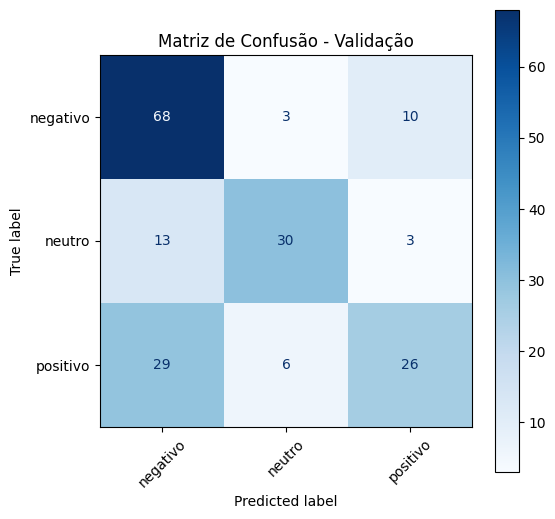

In [18]:
# Matriz de confusão
predictions_output = trainer_final.predict(tokenized_datasets["validacao"])
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

label_names = ["negativo", "neutro", "positivo"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Matriz de Confusão - Validação")
plt.xticks(rotation=45)
plt.grid(False)
plt.savefig('grafico_onda_seno.png')
plt.show()

Outra visualização

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
import shutil
import os

source_dir = "/content/modelo_final_elsa"
destination_dir = "/content/drive/MyDrive/modelo_final_elsa"

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

print(f"Folder '{source_dir}' copied to '{destination_dir}'")

Folder '/content/modelo_final_elsa' copied to '/content/drive/MyDrive/modelo_final_elsa'
